In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 10]

In [3]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE, MDS
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def preprocess(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

In [4]:
# load and randomize

yelps = pd.read_csv('sentiment/yelps.csv').sample(frac=1.)
movies = pd.read_csv('sentiment/movies.csv').sample(frac=1.)

## Inspecting p(X) of the BOW vectorizers

Assuming that our data consists of discrete features, as in the Bag of Words models we have seen so far, visualizing $p(X)$ consists of visualizing the PMF of a multionomial distribution that consists of all the features in our data. 

Of course, this is a very wide distribution, even if we just include unigrams. 

Thus, we will visualize just the most popular features. 

We will see how, given the most popular features of one dataset, the other dataset compares. 

In [5]:
from copy import deepcopy

def _train_and_transform(vectorizer, X):
    vectorizer.fit(X)
    return vectorizer, vectorizer.transform(X)

def compare(vectorizer, A, B):
    vec_A, VA = _train_and_transform(deepcopy(vectorizer), A) 
    vec_B, VB = _train_and_transform(deepcopy(vectorizer), B) 

    # Get the most popular words for A
    # ignoring the top 25 super common
    # words
    sums = np.array(VA.sum(0)).reshape(-1)
    tops = np.argsort(sums)[-325:-25]
    freqs_A = sums[tops]

    features = np.array(vec_A.get_feature_names())[tops]

    idxs = np.array([vec_B.vocabulary_.get(s) for s in features])
    sums = np.array(VB.sum(0)).reshape(-1)
    freqs_B = [sums[i] if i else 0. for i in idxs]

    return pd.concat([pd.DataFrame({ 'word': features, 'dataset': d, 'freq': f }) 
                      for d,f in [('A',freqs_A), ('B',freqs_B)]])

In [6]:
vectorizer = TfidfVectorizer(preprocessor = preprocess, min_df = 1, use_idf=False)
df = compare(vectorizer, yelps.sample(500).text, movies.sample(500).text)

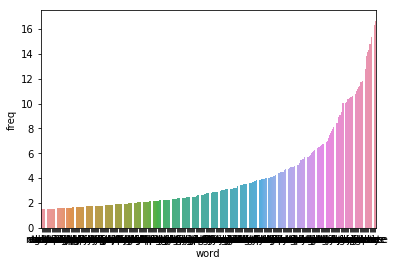

In [7]:
sns.barplot(x = 'word', 
            y = 'freq', 
            data = df[df.dataset == 'A'])

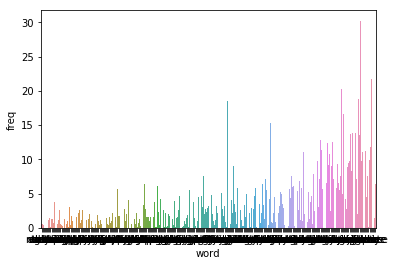

In [8]:
sns.barplot(x = 'word', 
            y = 'freq', 
            data = df[df.dataset == 'B'])

## Generative vs. Discriminative

Play around with the following plotting function. Is this consisten with the theoretical results of Ng and Jordan? Can you get the opposite results? Why? 

C:\Users\User\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\User\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\User\Anaconda3\lib\site-packages\bs4\__init__.py:335: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\User\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'...'" looks like 

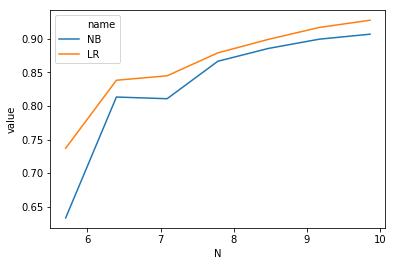

In [9]:
vectorizer = TfidfVectorizer(preprocessor = preprocess, min_df = 20, use_idf=False)
V = vectorizer.fit_transform(yelps.text)
y = yelps.positive

def _cv_score(V, y, models):
    return [{ 'name': name, 'value': np.mean(cross_val_score(model, V, y, cv=3)) }
            for name, model in models]

def plot_cv_scores(V, y, models, ticks):
    scores = [_cv_score(V[:t], y[:t], models) for t in ticks]        
    scores = [({'N': np.log(t) , **i}) for t,s 
              in zip(ticks, scores) for i in s]
    df = pd.DataFrame(scores)
    return sns.lineplot(y='value', x='N', hue='name', data=df)

models = [('NB', MultinomialNB(fit_prior=False)), 
          ('LR', LogisticRegression())]

plot_cv_scores(V, y, models, [300, 600, 1200, 2400, 4800, 9600, 19200])

## Searching the Grid

Hyperparameter tuning, in its simplest form, can be done via a grid search. 

We can use cross validation to estimate the out-of-sample expected risk. 

SKlearn gives us a very nice package for this: GridSearchCV

The API can be a bit complicated at first glance, but it's simple once you get used to it and comfortable with the idea of a "pipeline". 

## Crosstraining

Test how well your model, when trained on one dataset, performs on the other. 

To do this, make sure that you: 

1. You perform the "fitting" of both the vectorizer and the model on one of the sets
2. Use the "transform" of the vectorizer to transform the second dataset into the same feature space (X) that your model was trained on. 
3. Use the "predict" of your model to see how well it did on the second dataset. 

How well does your model generalize from one to the other? What does this say about "sentiment"? 

In [10]:
# Perform this on a smaller sample of the data to not break your machine

yelps = yelps.sample(1500)
movies = movies.sample(1500)

In [13]:
# creating a Tf vectorizer and applying the preprocessing function
vectorizer = TfidfVectorizer(preprocessor = preprocess, min_df = 1, use_idf=False)

# We will use the Yelps data set for training, and Movies - for test 
yelps_train = vectorizer.fit_transform(yelps.text)

movies_test = vectorizer.transform(movies.text)

### 1. Logistic regression

In [14]:
# Grid Search setup for Logistic Regression

from sklearn.model_selection import GridSearchCV

params = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000], 'tol':[0.001, 0.01, 0.1]}
clf = LogisticRegression()
cv = GridSearchCV(clf, params, cv=5, return_train_score=True) 

In [16]:
# Fitting the grid search:

best_model = cv.fit(yelps_train, yelps.positive)


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [17]:
print('Best Logistic Regression model:', cv.best_estimator_)

Best Logistic Regression model: LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.1, verbose=0, warm_start=False)


In [18]:
print('The in-sample cross-validated score is:', cv.best_score_)

The in-sample cross-validated score is: 0.924


In [28]:
# Predicting on the test set, using the best model obtained via grid search:
pred = best_model.predict(movies_test)

In [38]:
from sklearn import metrics
print('The Logistic regression model accuracy on the test set is:', metrics.accuracy_score(movies.positive, pred))

The Logistic regression model accuracy on the test set is: 0.7233333333333334


In [43]:
# Confusion matrix for the model:
metrics.confusion_matrix(movies.positive, pred)

array([[455, 299],
       [116, 630]], dtype=int64)

### 2. SVM

In [31]:
# Now let's try using SVM
from sklearn import svm

# Setting up grid search:

params_svm = {'kernel':('linear', 'rbf'), 'C':[0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}
clf_svm = svm.SVC()
cv_svm = GridSearchCV(clf_svm, params_svm, cv=5, return_train_score=True) 

In [32]:
# Fitting the grid search:

best_svm = cv_svm.fit(yelps_train, yelps.positive)

In [33]:
print('Best SVM model:', cv_svm.best_estimator_)

Best SVM model: SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [34]:
print('The in-sample cross-validated score is:', cv_svm.best_score_)

The in-sample cross-validated score is: 0.9186666666666666


In [37]:
# Predicting on the test set, using the best model obtained via grid search:
pred_svm = best_svm.predict(movies_test)

print('The SVM model accuracy on the test set is:', metrics.accuracy_score(movies.positive, pred_svm))

The SVM model accuracy on the test set is: 0.686


In [46]:
# Confusion matrix for the model:
metrics.confusion_matrix(movies.positive, pred_svm)

array([[443, 311],
       [160, 586]], dtype=int64)

### Using Logistic Regression, we obtained an accuracy of 72.33% on the test data (having a score of 92.4% in sample), whereas using SVM,  we obtained a score of 68.6% (having a score of 91.867% in sample). So in both cases the accuracy is definitely not good, the models generalize pretty bad. This suggests that the sentiment in the language of reviews in the Yelps data set is somewhat 'different' from the one in the Movie reviews. Hence, it is probably not useful to predict sentiment in the Movie reviews using what we have inferred for the sentiment in Yelps reviews.

### Looking at the confusion matrices for both cases, we see that the ratio (False Positives / All Positives) is slightly higher than the ratio (False Negatives / All Negatives), i.e. we more often make the mistake to classify a negative review as positive. If the real sentiment in a movie review was positive, we have a higher chance to detect it correctly. 